# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [1]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import numpy.ma as ma
from multiprocessing import Pool
from scipy.optimize import minimize
from biokey.data import DataInterface
import biokey.tools
from biokey.tools import parallel_process
import json
import random
# This makes plots render inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
% matplotlib inline

In [3]:
data = DataInterface(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Loaded dwell and flight from cache
Done Loading



In [4]:
key_press_count = data.get_dwells().key.value_counts()
mask = list(string.ascii_uppercase)
mask.extend(['ESCAPE', 'ENTER', 'SPACE', 'CONTROL', 'META', 'BACKSPACE', 'SHIFT'])

In [5]:
datasets = data.get_all_sets()
# for u in datasets:
#     datasets[u] = biokey.tools.filter_sets(datasets[u], to_include=mask)

# Building Profile Using Threshold

In [6]:
from scipy.stats import ttest_ind_from_stats

class Node(object):
    def __init__(self, name):
        self.name = name
        self.children = {}
        self.stats = None
        self.parent = None
    def add(self, hash1):
        self.children[hash1.name] = hash1
        self.parent = self
        return hash1
    def goto(self, name):
        if(name in self.children):
            return self.children[name]

class Profile(object):
    def __init__(self, df, threshold, trim=None):
        self.trimmed = trim
        self.threshold = threshold
        if data is not None and threshold is not None:
            self._build_profile(df, threshold)
            if trim:
                self.profile = self.profile.loc[self.profile['count'] >= trim]
                self._build_tree()
    
    def _build_profile(self, df, t):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = None
        seqs = []
        count = -1
        for row in df.itertuples():
            count += 1
            row = {
                'key': row.key,
                'down': row.down,
                'up': row.up,
                'interval': row.interval,
                'count': count
            }
            if start == None:
                # First after threshold
                start = row
            else:
                # Nth after threshold - queue as starters
                inner_queue.append(row)
            # Add it to the chain
            chain.append(str(row['key']))
            seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
            # If threshold is not met then start again
            if row['interval'] > t:
                for i in range(len(inner_queue)):
                    start = inner_queue[i]
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(row['key']))
                        seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
                chain = []
                inner_queue = []
                start = None
        # Aggregate sequences
        self.seqs = pd.DataFrame(seqs)
        s = self.seqs.copy()
        s.loc[:,'log_duration'] = np.log(s.duration)
        seq_dur = s.groupby('seq').aggregate(['mean', 'std', 'count']).log_duration
        # Fill missing values with a proxy
        seq_dur['std'] = seq_dur['std'].fillna((seq_dur['std']/seq_dur['mean']).mean()*seq_dur['mean'])
        self.profile = seq_dur
        self._build_tree()
    
    def update_profile(self, df):
        self.profile = df
        self._build_tree()
    
    def diversify(self, other_profile):
        compared_profiles = pd.merge(self.profile, other_profile.profile, left_index=True, right_index=True)
        compared_profiles['pvalue'] = compared_profiles.apply((lambda x: ttest_ind_from_stats(x.mean_x, x.std_x, x.count_x, x.mean_y, x.std_y, x.count_y, False).pvalue), axis=1)
        new_profile = compared_profiles.loc[compared_profiles.pvalue < 0.05,['mean_x', 'std_x', 'count_x']]
        new_profile.columns = ['mean', 'std', 'count']
        self.update_profile(new_profile)
        
    def _build_tree(self):
        self.root = Node('root')
        for s, row in self.profile.iterrows():
            n = self.root
            for k in s.split('-'):
                new = n.goto(k)
                if not new:
                    new = n.add(Node(k))
                n = new
            n.stats = row.to_dict()
            
    def trim(self, n):
        "Returns a new profile, trimmed to sequences with n instances"
        new_p = Profile(None, self.threshold, n)
        new_p.profile = self.profile.loc[self.profile['count'] >= n]
        new_p.seqs = self.profile.loc[self.seqs.seq.isin(self.profile.index)]
        new_p._build_tree()
        return new_p
    
    def search_tree(self, path):
        "Search tree for the node at a given list path"
        n = self.root
        for p in path:
            new = n.goto(p)
            if not new:
                return None
            n = new
        return n
    
    def features(self):
        return np.array(self.profile.index)

    def test_distance(self, path, duration):
        "Returns the probability that a typed path's duration was the profiles's"
        node = self.search_tree(path)
        if node is None or node.stats is None:
            return -1
        stats = node.stats
        return np.exp(-np.square((np.log(duration)-stats['mean']))/(2*np.square(stats['std'])))
        
    def test_window(self, df):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = -1
        instances = {}
        results = {}
        
        for f in self.features():
            instances[f] = []
            results[f] = 0
        for row in df.itertuples():
            if start == -1:
                start = row.down
            else:
                inner_queue.append(row)
            chain.append(str(row.key))
            seq = '-'.join(chain)
            if seq in instances:
                instances[seq].append(self.test_distance(chain, row.up - start))
            if row.interval > self.threshold:
                for i in range(len(inner_queue)):
                    start = inner_queue[i].down
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(r.key))
                        seq = '-'.join(chain)
                        if seq in instances:
                            instances[seq].append(self.test_distance(chain, r.up - start))
                chain = []
                inner_queue = []
                start = -1
                
        for f in instances:
            durations = instances[f]
            if len(durations) > 0:
                results[f] = np.mean(durations)
        return pd.Series(results)

In [7]:
userid_valid = data.get_users()[2]
train = datasets[userid_valid].train
test = datasets[userid_valid].test

train_valid = train.loc[train.is_user]
train_imposter = train.loc[train.is_user == False]

test_valid = test.loc[test.is_user]
test_imposter = test.loc[test.is_user == False]

# user_threshold = optimals[userid_valid]
seq_cutoff_threshold = 150
seq_occurance_threshold = 30

In [8]:
p = Profile(train_valid, seq_cutoff_threshold, trim=seq_occurance_threshold)

## Load Frames

In [9]:
frames = json.load(open('windowed_frames_class_40.json'))
test_frames = json.load(open('windowed_frames_class_40_test.json'))

# Build LSTM Model

In [10]:
from keras.models import Model
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Input, RepeatVector
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
input_features = len(p.features())
input_feature_dimensions = 2 # score, count
lookback_window = 50

num_samples = len(frames) - lookback_window

input_shape = (lookback_window, input_feature_dimensions*input_features)

num_layers = 2
layer_size = 64

batch_size = 32

output_shape = (1)

epochs = 10

In [12]:
features = p.features()
feature_indexes = {}
for i in range(len(features)):
    feature_indexes[features[i]] = i

In [13]:
# With Count
def parse_frame(f, feature_indexes):
    y = int(f['y'])
    x = np.zeros((len(feature_indexes), 2))
    for s in f['x']:
        try:
            i = feature_indexes[s]
            x[i][0] = f['x'][s]['mean']
            x[i][1] = f['x'][s]['count']
        except:
            pass
    return x, y

def gen_rand_frame(frames, batch_size=64, feature_indexes=feature_indexes):
    while True:
        batch_x = []
        batch_y = []
        for i in range(batch_size):
            x, y = parse_frame(frames[random.randint(0, len(frames)-1)], feature_indexes)
            batch_x.append(x)
            batch_y.append(y)
        # x = np.array(batch_x).reshape((batch_size, len(feature_indexes)*2))
        x = np.array(batch_x)[:,:,0]
        yield x, x

In [29]:
# With Count
def create_window(frames, feature_indexes, start, lookback):
    x_vals = []
    y = None
    for i in range(lookback):
        x, y = parse_frame(frames[start+i], feature_indexes)
        x_vals.append(x[:,0])
    return np.array(x_vals), y

def gen_rand_window(frames, feature_indexes, lookback,  batch_size=32):
    """
    Generator to yield inputs and their labels in batches.
    """
    while True:
        batch_x = []
        batch_y = []
        for i in range(batch_size):
            x, y = create_window(frames, feature_indexes, random.randint(0, len(frames)-lookback-1), lookback)
            batch_x.append(x)
            batch_y.append(y)
        x = np.array(batch_x)
        yield x, x

def gen_window_default(frames):
    return gen_rand_window(frames, feature_indexes, lookback_window, batch_size)

In [15]:
# Deep MLP
inputs = Input((input_features,))

encoded = Dense(256, activation='relu')(inputs)
encoded = Dense(128, activation='relu')(encoded)
# encoded = Dense(64, activation='relu')(encoded)
# encoded = Dense(32, activation='relu')(encoded)

# decoded = Dense(64, activation='relu')(encoded)
# decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(input_features, activation='sigmoid')(decoded)

# compile model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
run_name = str(datetime.now()).replace(':','.').replace('.','_')
filepath="./gaussian-lstm-models/%s-weights-{epoch:02d}-{val_loss:.2f}.hdf5" % run_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tbCallBack = TensorBoard(log_dir='./Graph/Gaussian_LSTM_%s/' % run_name, histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]

autoencoder.fit_generator(gen_rand_frame(frames), validation_data=gen_rand_frame(test_frames), validation_steps=200, epochs=5, steps_per_epoch=1000, callbacks=callbacks_list)

Epoch 1/5
 998/1000 [============================>.] - ETA: 0s - loss: 0.1134 - acc: 0.9521
Epoch 00001: val_loss improved from inf to 0.08507, saving model to ./gaussian-lstm-models/2018-03-06 15_28_53_619709-weights-01-0.09.hdf5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1133 - acc: 0.9521 - val_loss: 0.0851 - val_acc: 0.9624
Epoch 2/5
 994/1000 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9632
Epoch 00002: val_loss improved from 0.08507 to 0.08073, saving model to ./gaussian-lstm-models/2018-03-06 15_28_53_619709-weights-02-0.08.hdf5
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0815 - acc: 0.9632 - val_loss: 0.0807 - val_acc: 0.9620
Epoch 3/5
 994/1000 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9629
Epoch 00003: val_loss improved from 0.08073 to 0.07760, saving model to ./gaussian-lstm-models/2018-03-06 15_28_53_619709-weights-03-0.08.hdf5
1000/1000 [==============================] - 6s 6ms/s

In [30]:
# Deep LSTM
# create model
inputs = Input((lookback_window, input_features))
# add layers
encoded = CuDNNLSTM(64)(inputs)
decoded = RepeatVector(lookback_window)(encoded)
decoded = CuDNNLSTM(input_features, return_sequences=True)(decoded)

# compile model
lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
run_name = str(datetime.now()).replace(':','.').replace('.','_')
filepath="./gaussian-lstm-models/%s-weights-{epoch:02d}-{val_loss:.2f}.hdf5" % run_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tbCallBack = TensorBoard(log_dir='./Graph/Gaussian_LSTM_%s/' % run_name, histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]

lstm_autoencoder.fit_generator(gen_window_default(frames), validation_data=gen_window_default(test_frames), validation_steps=200, epochs=10, steps_per_epoch=1000, callbacks=callbacks_list)

Epoch 1/10
 998/1000 [============================>.] - ETA: 0s - loss: 0.1133 - acc: 0.9640
Epoch 00001: val_loss improved from inf to 0.10694, saving model to ./gaussian-lstm-models/2018-03-06 15_49_36_093350-weights-01-0.11.hdf5
1000/1000 [==============================] - 60s 60ms/step - loss: 0.1133 - acc: 0.9640 - val_loss: 0.1069 - val_acc: 0.9629
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9640
Epoch 00002: val_loss improved from 0.10694 to 0.10588, saving model to ./gaussian-lstm-models/2018-03-06 15_49_36_093350-weights-02-0.11.hdf5
1000/1000 [==============================] - 58s 58ms/step - loss: 0.0991 - acc: 0.9640 - val_loss: 0.1059 - val_acc: 0.9631
Epoch 3/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9639
Epoch 00003: val_loss improved from 0.10588 to 0.09540, saving model to ./gaussian-lstm-models/2018-03-06 15_49_36_093350-weights-03-0.10.hdf5
1000/1000 [==============================] - 5

In [44]:
x, _ = next(gen_window_default(frames))
lstm_autoencoder.predict(x)

array([[[ 0.02237167,  0.00387558,  0.00400804, ..., -0.02168353,
         -0.0139424 ,  0.06307534],
        [ 0.03076789,  0.00233694,  0.00594454, ..., -0.038707  ,
         -0.02620566,  0.09553093],
        [ 0.03090568, -0.00103678,  0.00640228, ..., -0.05119434,
         -0.03696568,  0.11314356],
        ...,
        [-0.04481667, -0.02125395, -0.00829104, ..., -0.08773251,
         -0.0896745 ,  0.15114425],
        [-0.04481842, -0.02125397, -0.00829148, ..., -0.08773296,
         -0.0896753 ,  0.15114471],
        [-0.04481981, -0.02125397, -0.00829183, ..., -0.08773332,
         -0.08967594,  0.15114512]],

       [[ 0.03646297,  0.0062576 ,  0.00717731, ..., -0.02106157,
         -0.01864267,  0.03268223],
        [ 0.05420016,  0.00600061,  0.01058725, ..., -0.03315507,
         -0.03268186,  0.04714882],
        [ 0.06118905,  0.00357995,  0.01218734, ..., -0.04026815,
         -0.0428572 ,  0.05391273],
        ...,
        [ 0.02734142, -0.01227815,  0.00522157, ..., -

## Test It

In [18]:
def far(y_true, y_pred, thresh=0.5):
    total_false = np.equal(y_true, 0).astype('int32').sum()
    false_accepts = (np.equal(y_true, 0) & np.greater_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_accepts/total_false

def frr(y_true, y_pred, thresh=0.5):
    total_accept = np.equal(y_true, 1).astype('int32').sum()
    false_rejects = (np.equal(y_true, 1) & np.less_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_rejects/total_accept

In [19]:
def evaluate(x, y, model, model_path='LSTM Model', index=0, plot=True):
    y_pred = model.predict(x)

    fpr, tpr, thresholds = metrics.roc_curve(y,  y_pred)
    auc = metrics.roc_auc_score(y, y_pred)
    plt.plot(fpr,tpr,label="LSTM"+str(index)+", auc="+str(auc))

    false_accepts = far(y.flatten(), y_pred.flatten())
    false_rejects = frr(y.flatten(), y_pred.flatten())
    accuracy = metrics.accuracy_score(y.flatten(), np.round(y_pred.flatten()))
    print('Model: %s (FAR: %4f FRR: %4f ACC: %4f)' % (model_path, false_accepts, false_rejects, accuracy))
    
    if plot:
        plt.legend(loc=4)
        plt.show()

def evaluate_many(x_data, y_data, model_paths):
    index = 0
    for m in model_paths:
        lstm_model.load_weights(m)
        evaluate(x_data, y_data, lstm_model, m, index=index, plot=False)
        index = index + 1
    plt.legend(loc=4)
    plt.show()

In [27]:
lstm_model.load_weights('./gaussian-lstm-models/2018-03-06 04_24_13_418869-weights-02-0.25.hdf5')

In [31]:
x_train, y_train = next(gen_window(frames, feature_indexes, lookback_window, 1000))
x_test, y_test = next(gen_window(test_frames, feature_indexes, lookback_window, 1000))

Model: LSTM Model (FAR: 0.017926 FRR: 0.132420 ACC: 0.957000)


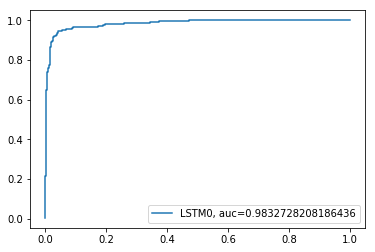

In [32]:
evaluate(x_train, y_train, lstm_model)

Model: LSTM Model (FAR: 0.044723 FRR: 0.628118 ACC: 0.698000)


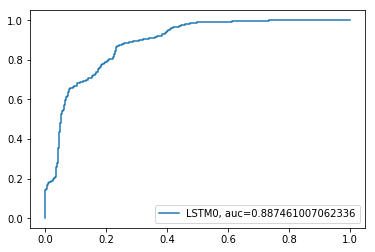

In [37]:
evaluate(x_test, y_test, lstm_model)

In [38]:
y_tests = []
y_test_preds = []

for i in tnrange(100):
    x_test, y_test = next(gen_window(test_frames, feature_indexes, lookback_window, 1000))
    y_tests.append(y_test)
    y_pred = lstm_model.predict(x_test)
    y_test_preds.append(y_pred)

y_tests = np.array(y_tests).flatten()
y_test_preds = np.array(y_test_preds).flatten()

HBox(children=(IntProgress(value=0), HTML(value='')))

FAR: 0.044723 FRR: 0.628118 ACC: 0.698000


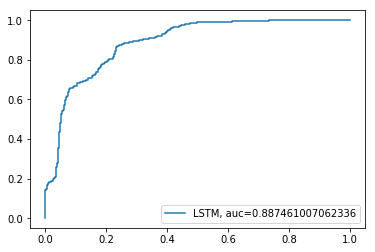

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(y_tests,  y_test_preds)
auc = metrics.roc_auc_score(y_tests, y_test_preds)
plt.plot(fpr,tpr,label="LSTM, auc="+str(auc))

false_accepts = far(y_tests, y_test_preds)
false_rejects = frr(y_tests, y_test_preds)
accuracy = metrics.accuracy_score(y_tests, np.round(y_test_preds))
print('FAR: %4f FRR: %4f ACC: %4f' % (false_accepts, false_rejects, accuracy))
plt.legend(loc=4)
plt.show()

In [42]:
comp = pd.DataFrame({'predictions': y_test_preds, 'actual': y_tests})

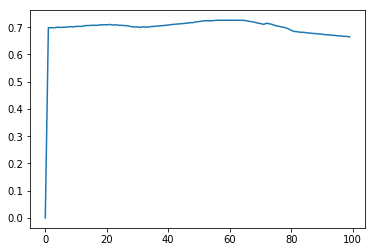

In [49]:
pd.Series(range(100)).apply(lambda x: (comp.predictions.rolling(x).mean().round() == comp.actual).mean()).plot()